# A neural probabilistic language model
Idea, map words (chars in our case) to a latent space, s.t. similar words in meaning (or semantically close) are close to each other 
s.t. then at inference time even if the nn has not seen the particular sequence of words that is being processed, it can use 
the similarity in the latent space to do "analogy" :

example:\
"the dog walks ..."\
suppose that the nn has to predict the next word, and we did not have this phrase in our train set but we had:\
"a cat runs fast"\
the idea is that the nn can "understad" that the/a are interchangeable in terms of semantic, same for cat/dog

In [1]:
import torch
import torch.nn.functional as F
import random
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

# Network architecture:

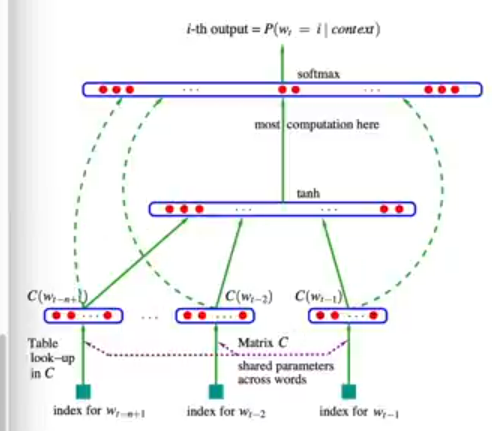

In [2]:
display.Image("/home/marconobile/Desktop/karpathy/3mlp_architecture.png")

# Dataset

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:5], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [4]:
# build mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi, itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words):
    global ctx_len
    ctx_len = 3  # context lenght: we use 3 previous character to predict next char
    X, Y = [], []
    
    for w in words:
        # print('next word:', w)
        ctx = [0] * ctx_len
        for ch in w + '.':
            ix = stoi[ch] # get int version of next char, this is target
            X.append(ctx) # list of 3 ints, each char in ctx
            Y.append(ix) # next char as int
            # print(f"{''.join(list(map(lambda i: itos[i], ctx )))} ===> {itos[ix]}")
            ctx = ctx[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

Usually you split data in:
- train
- validation/development: to tune hyperparams, early stop, evaluate over/under fitting etc
- test: just rarely at end of major steps, you must not take choices just to fit this set cuz otherwise you cannot generalize in real world

In [6]:
random.shuffle(words)
n1 = int(.8*len(words))
n2 = int(.9*len(words))

xtrain, ytrain = build_dataset(words[:n1])
xvalid, yvalid = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])

xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape, xtest.shape, ytest.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

# MLP Layer math

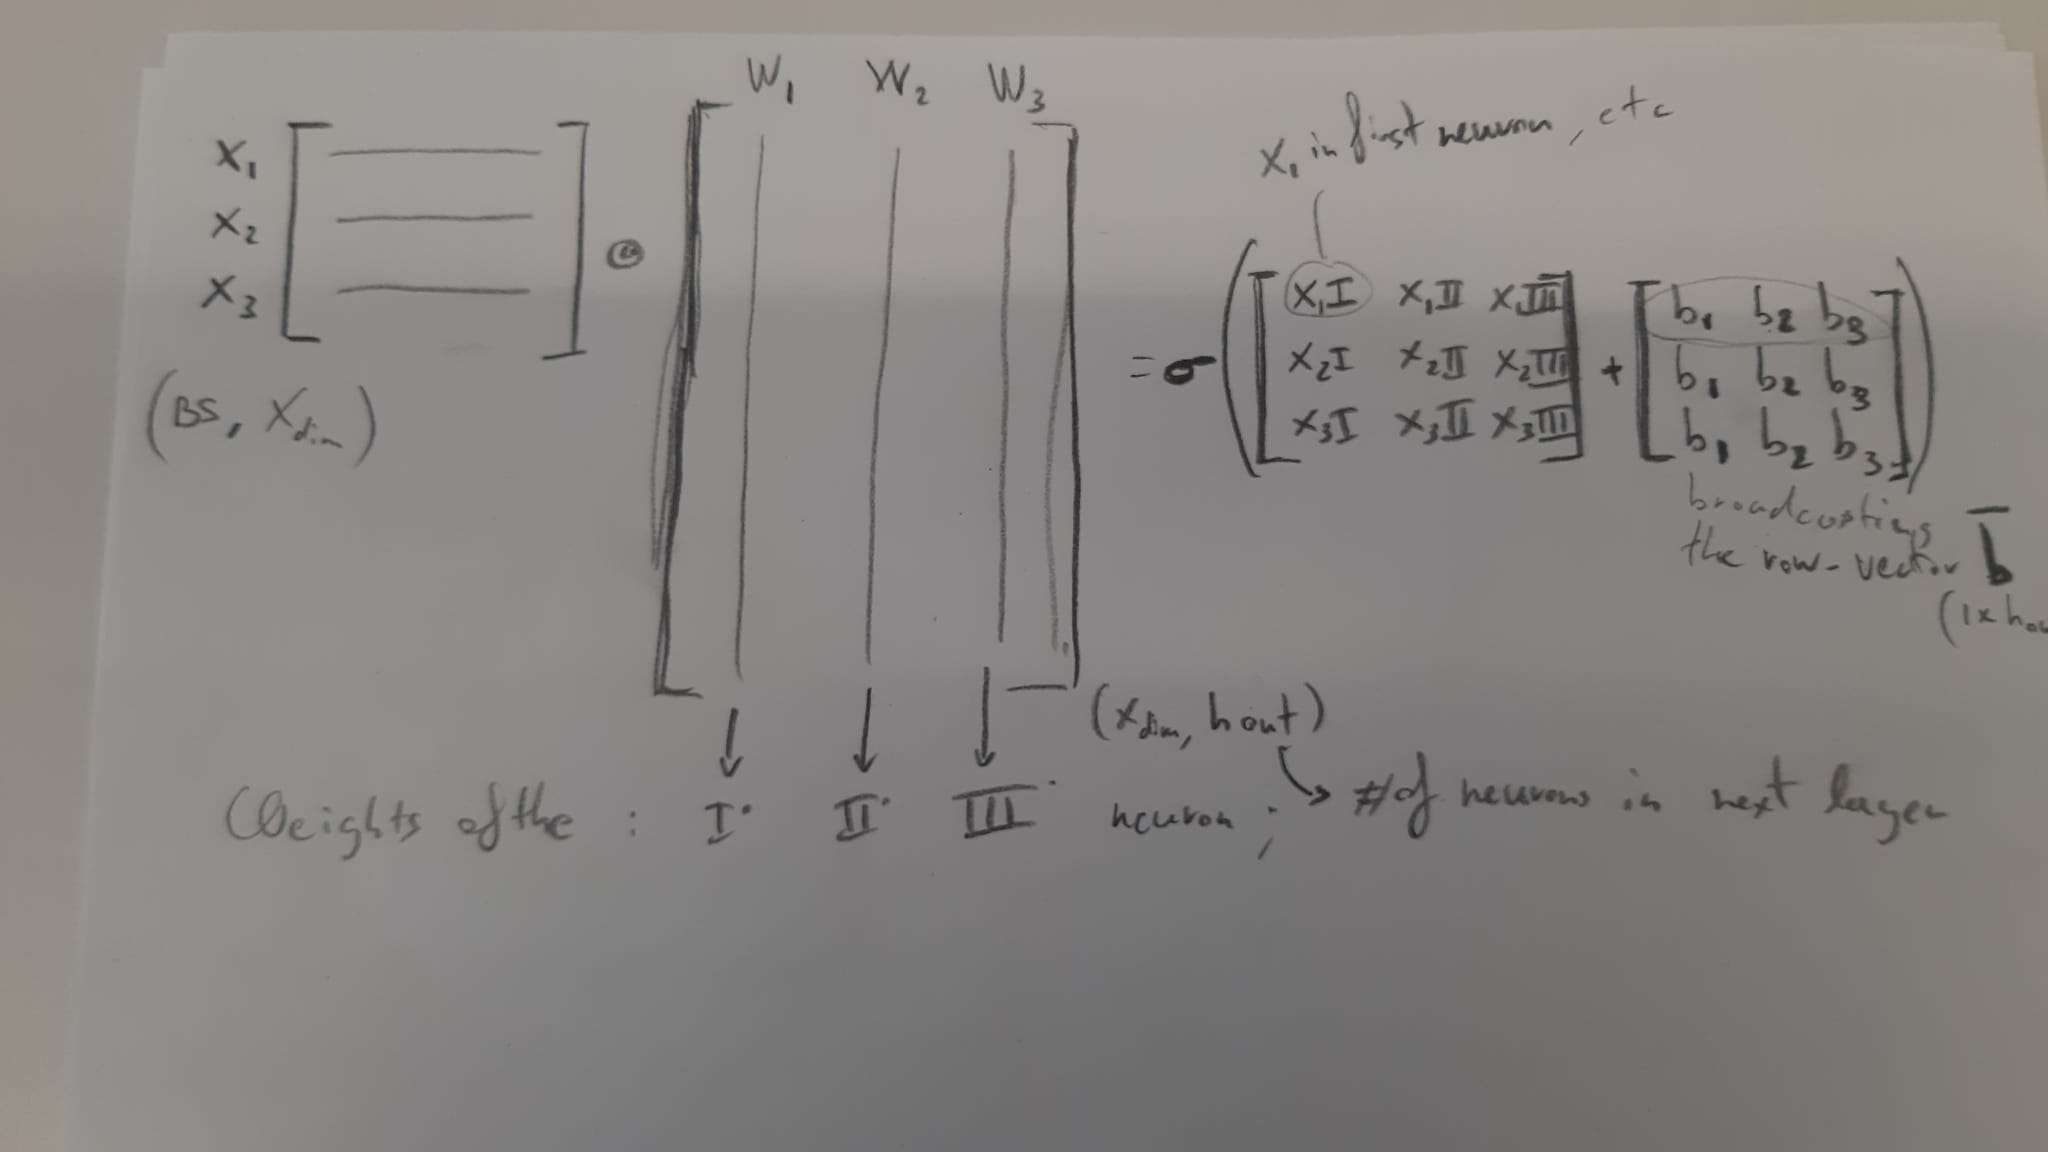

In [7]:
display.Image("/home/marconobile/Desktop/karpathy/mlp_layer.jpeg")

# Overfit a batch
We started by developing all the network using a single fixed batch, with the goal of overfitting it.
We could not drive the loss to 0 becuz we always predict something wrong:\
... -> first_letter
is always wrong cuz in our batch we have that from ... we need to predict:\
e for emma, a for ava, etc, so we will always make mistake in these cases, we cant just memorize the batch!

In [8]:
def reset_grads(params):
    '''
    params: iterable containing params tensors
    '''
    for p in params:
        p.grad = None

def update_params(params, lr):
    '''
    params: iterable containing params tensors
    lr: learning rate
    '''    
    for p in params:
        p.data += - lr * p.grad

# Find LR

In [9]:
# initialize
emb_size = 2
hidden_shape1 = 300 # number of out neurons, thus we need hidden_shape1 biases

C  = torch.randn((27, emb_size), requires_grad=True)
W1 = torch.randn((ctx_len*emb_size, hidden_shape1), requires_grad=True)
b1 = torch.randn(W1.shape[1], requires_grad=True)
W2 = torch.randn((W1.shape[1], len(stoi.keys())), requires_grad=True)
b2 = torch.randn(len(stoi.keys()), requires_grad=True)

parameters = [C, W1, b1, W2, b2]

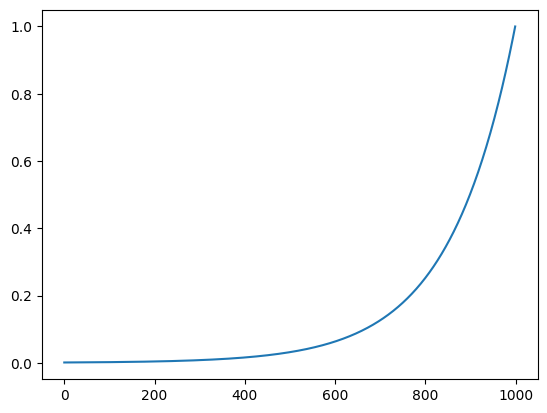

In [10]:
max_linsp = 1000
lre = torch.linspace(-3, 0, max_linsp) # get linspace of exponents of 10**linspaced vals from [10e-3; 10e-0] = [0.001 to 1] 
lrs = 10**lre # actual lrs to be tested
plt.plot(lrs) # we want to search between these 1000 lrs

/home/marconobile/miniconda3/envs/karpathyAI/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


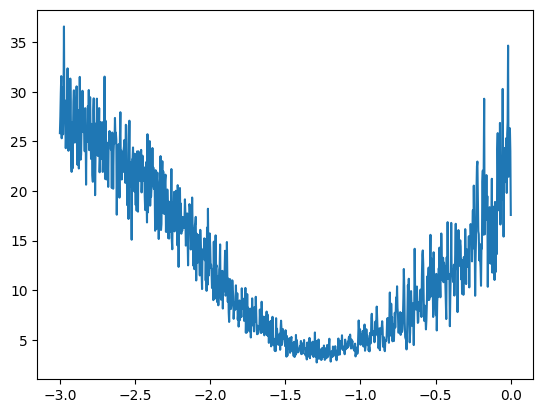

In [11]:
# let's find the best lr for our case
lri, lossi = [], []
for i in range(max_linsp):

    batch_idx = torch.randint(0, xtrain.shape[0], (32,)) # select a random batch and use only this obs to estimate the gradient
    
    emb = C[xtrain[batch_idx]]
    h1 = torch.tanh(emb.view(-1, ctx_len*emb_size) @ W1 + b1) # ALWAYS USE VIEW
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, ytrain[batch_idx])    
    reset_grads(parameters)
    loss.backward()
    update_params(parameters, lrs[i])    
    lri.append(lre[i])
    lossi.append(loss.item())

plt.plot(lri, lossi) # 10 ** -1 is good, use the one u got when overfitting a single batch


# USING TRAIN/VAL/TEST SPLITS

In [12]:
# initialize
emb_size = 2
hidden_shape1 = 300 # number of out neurons, thus we need hidden_shape1 biases
batch_size = 128

C  = torch.randn((27, emb_size), requires_grad=True)
W1 = torch.randn((ctx_len*emb_size, hidden_shape1), requires_grad=True)
b1 = torch.randn(W1.shape[1], requires_grad=True)
W2 = torch.randn((W1.shape[1], len(stoi.keys())), requires_grad=True)
b2 = torch.randn(len(stoi.keys()), requires_grad=True)

parameters = [C, W1, b1, W2, b2]

2.0965609550476074

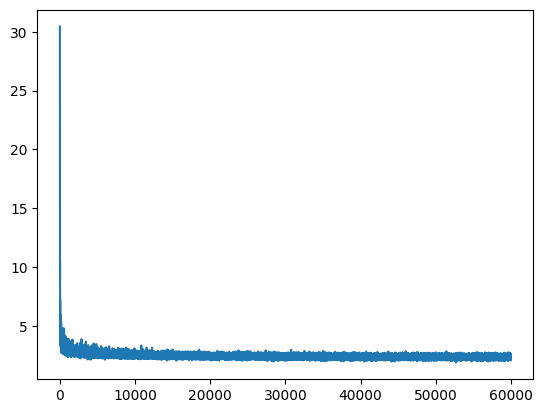

In [13]:
losses, iter = [], []
for i in range(60000):

    batch_idx = torch.randint(0, xtrain.shape[0], (batch_size,)) # select a random batch and use only this obs to estimate the gradient
    # 32 is batch size, if batch size is too low, too much variance in grad direction and we fail to optimize
    
    emb = C[xtrain[batch_idx]]
    h1 = torch.tanh(emb.view(-1, ctx_len*emb_size) @ W1 + b1) 
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, ytrain[batch_idx])
    losses.append(loss.item())
    iter.append(i)
    reset_grads(parameters)
    loss.backward()
    update_params(parameters, .1) 

plt.plot(iter, losses)
losses[-1]

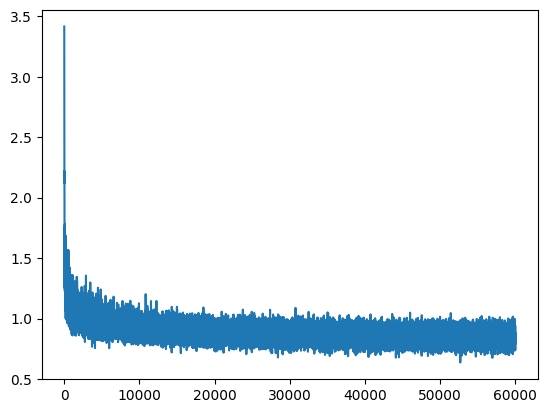

In [14]:
import math
plt.plot(iter, [math.log(x) for x in losses])
# we have this "thickness" in the loss tail cuz of the variance due to the gradient estimante over the mini batch

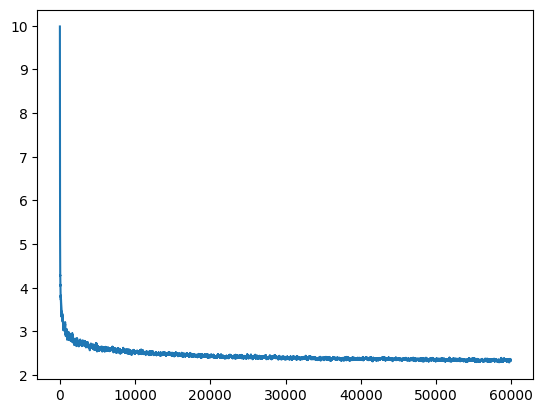

In [15]:
import numpy as np
N = 50 # window size
l = np.convolve(losses, np.ones(N)/N, mode='valid')
plt.plot([i for i in range(len(l))], l)

In [16]:
losses, iter = [], []
for i in range(60000):

    batch_idx = torch.randint(0, xtrain.shape[0], (batch_size,)) # select a random batch and use only this obs to estimate the gradient
    
    emb = C[xtrain[batch_idx]]
    h1 = torch.tanh(emb.view(-1, ctx_len*emb_size) @ W1 + b1) 
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, ytrain[batch_idx])
    losses.append(loss.item())
    iter.append(i)
    reset_grads(parameters)
    loss.backward()
    update_params(parameters, .05) 

2.3242924213409424

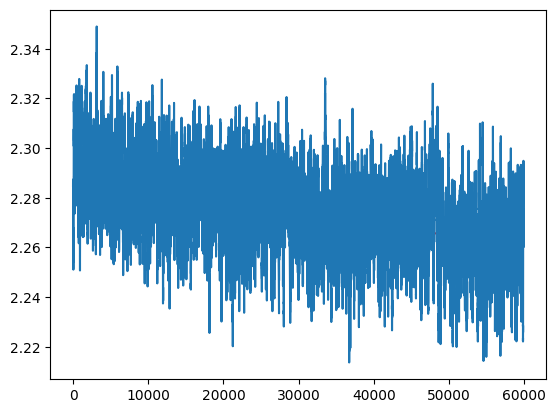

In [17]:
l = np.convolve(losses, np.ones(N)/N, mode='valid')
iter = [i for i in range(len(l))]

z = np.polyfit(iter, l, 1)
p = np.poly1d(z)
plt.plot(iter,p(iter),"r--")
plt.plot(iter, l)
losses[-1]

2.3201205730438232

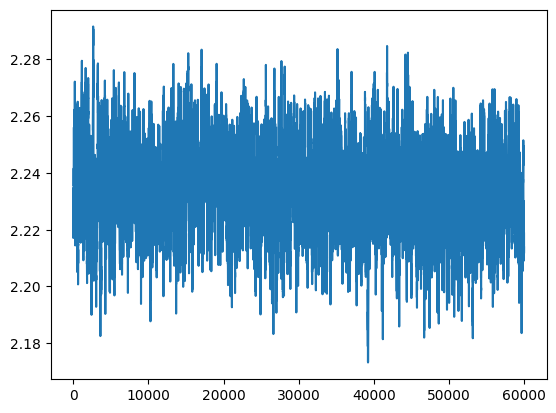

In [18]:
losses, iter = [], []
for i in range(60000):

    batch_idx = torch.randint(0, xtrain.shape[0], (batch_size,)) # select a random batch and use only this obs to estimate the gradient
    
    emb = C[xtrain[batch_idx]]
    h1 = torch.tanh(emb.view(-1, ctx_len*emb_size) @ W1 + b1) 
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, ytrain[batch_idx])
    losses.append(loss.item())
    iter.append(i)
    reset_grads(parameters)
    loss.backward()
    update_params(parameters, .01) 

l = np.convolve(losses, np.ones(N)/N, mode='valid')
iter = [i for i in range(len(l))]

z = np.polyfit(iter, l, 1)
p = np.poly1d(z)
plt.plot(iter,p(iter),"r--")
plt.plot(iter, l)
losses[-1]

In [19]:
# evaluation on the full train
emb = C[xtrain]
h1 = torch.tanh(emb.view(-1, ctx_len*emb_size) @ W1 + b1) 
logits = h1 @ W2 + b2
loss = F.cross_entropy(logits, ytrain)
print(loss)

tensor(2.2305, grad_fn=<NllLossBackward0>)


In [20]:
# evaluation on the valid
emb = C[xvalid]
h1 = torch.tanh(emb.view(-1, ctx_len*emb_size) @ W1 + b1) 
logits = h1 @ W2 + b2
loss = F.cross_entropy(logits, yvalid)
print(loss)

tensor(2.2412, grad_fn=<NllLossBackward0>)


As we can see we achieve 2.3278 on the whole train, and 2.3259 on dev set, this implies that we are not overfitting: the model is not large enough to memorize train data. \
This implies that we are underfitting (<- when train and dev loss are equal): scale up size of nn


After increasing the hidden size of the hidden layer and the batch size to get a better estimate of the gradient we still have roughly 
the same values of loss for train set and val set, this might imply that the bottleneck is in the embedding size of the characters, which in the beginning is 2d for sake of visualization

In [21]:
# # evaluation on the test
# emb = C[xtest]
# h1 = torch.tanh(emb.view(-1, ctx_len*emb_size) @ W1 + b1) 
# logits = h1 @ W2 + b2
# loss = F.cross_entropy(logits, xtest)
# print(loss)

# Embedding space visualization

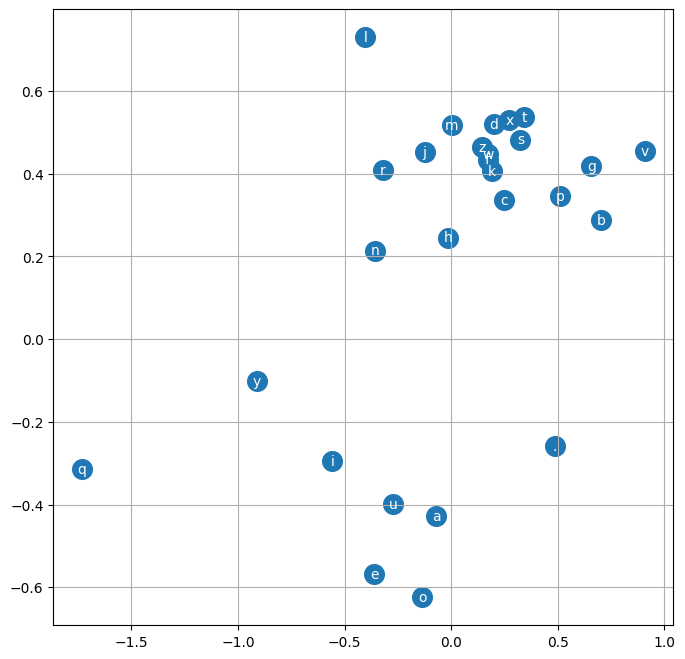

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')
# wovels split from other chars =D, q and . are quite far from everything else, other consonant are closer to each other

# Increase embedding size

Optimize all params as much as you can for validation/dev set performance ONLY, and use that model on test set at the end.

- step 1: initialization
